In [20]:
%matplotlib inline

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import scipy.stats as st

import re
import zipfile
import os

# Mental disorders analysis

## Introduction

## Plan
Although the project title is *Mental disorders analysis*, we are going to analize only a few like depression, anxiety and Obsessive Compulsive Disorder

Some words why I chose the datasets

Some questions to ask

Approaches

At the beginning we are going to clean some datasets. Then we will proceed to make some hypotesis and prove or reject them. We are also going to compare results from multiple datasets.

Then we will try to train a model using Regression that will try to predict whether a person has any of the above mentioned disorders.

In the end, we will try to find typical behavior for those disorders and then compare it to other disorders.

## Data Cleanup

Let's begin by creating a function that will be used for renaming columns to *snake_case*

In [22]:
def to_snake_case(col_name):
    col_name = col_name.strip()
    col_name = col_name.lower()
    col_name = re.sub(r"[^\w\s]", "_", col_name) # replace non-alphanumeric characters with underscores
    col_name = re.sub(r"\s+", "_", col_name) # regex is used instead of replace to handle multiple spaces
    col_name = re.sub(r"_+", "_", col_name)  # replace multiple underscores with a single underscore
    col_name = col_name.rstrip("_")

    return col_name

Since one of the datasets is into a zip file and we want the notebook to be as reproducable as possible, we are going to create a function that extracts files from zips

In [23]:
def extract_zip(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

Also, one of the datasets is a .xlsx format (Excel). We need a function to use it in .csv format.

In [24]:
def xlsx_to_csv(xlsx_path, csv_path):
    df = pd.read_excel(xlsx_path)
    df.to_csv(csv_path, index=False)

Because we will mostly work with numerical data, we need a way to represent categorical data as integers.

In [25]:
# val1 and val2 are case insensitive and default to 'yes' and 'no'
def binary_encode(df, column, val1 = 'yes', val2 = 'no'):
    df[column] = df[column].str.lower().map({val1.lower(): 1, val2.lower(): 0})

In [26]:
# nominal encoding using OneHotEncoder
def one_hot_encode(df, column):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
    ohetransform = ohe.fit_transform(df[[column]])
    df = pd.concat([df, ohetransform], axis=1).drop(column, axis=1)

In [27]:
def ordinal_encode(df, column, categories_order):
    # Transform both the list and the column to lowercase for consistency and case insensitivity
    categories_order_lower = [cat.lower() for cat in categories_order]
    df[column] = df[column].str.lower()

    encoder = OrdinalEncoder(categories=[categories_order_lower])
    df[column] = encoder.fit_transform(df[[column]])

Of course, we will need some plotting functions

In [28]:
def plot_category_counts(df, column_name, title=None, xlabel=None, ylabel="Count"):
    category_stats = df[column_name].value_counts()
    
    categories = category_stats.index
    counts = category_stats.values

    plt.bar(categories, counts)
    plt.title(title if title else f"Students by {column_name}")
    plt.xlabel(xlabel if xlabel else column_name)
    plt.ylabel(ylabel)

    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.show()

### Student Depression

Let's start with the Student Depression Dataset.csv dataset.

In [29]:
student_depression_data = pd.read_csv('data/Student Depression Dataset.csv')

In [30]:
student_depression_data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [31]:
student_depression_data.columns = [to_snake_case(c) for c in student_depression_data.columns]

First thing we notice is that there is a column *id* which we need to check for uniqueness

In [32]:
student_depression_data.id.nunique() == len(student_depression_data)

True

Since it has no repetitions we can safely remove the column

In [33]:
student_depression_data = student_depression_data.drop(columns=["id"])

First thing we notice is that the dataset contains a column named Profession. However, that column includes Student as a value. We also have Work/Study Hours.

In [34]:
profession_stats = student_depression_data.profession.value_counts()
profession_stats.columns = ["Profession", "Count"]
profession_stats

profession
Student                   27870
Architect                     8
Teacher                       6
Digital Marketer              3
Chef                          2
Content Writer                2
Pharmacist                    2
Doctor                        2
UX/UI Designer                1
Civil Engineer                1
Manager                       1
Educational Consultant        1
Lawyer                        1
Entrepreneur                  1
Name: count, dtype: int64

The bar chart says it all :)

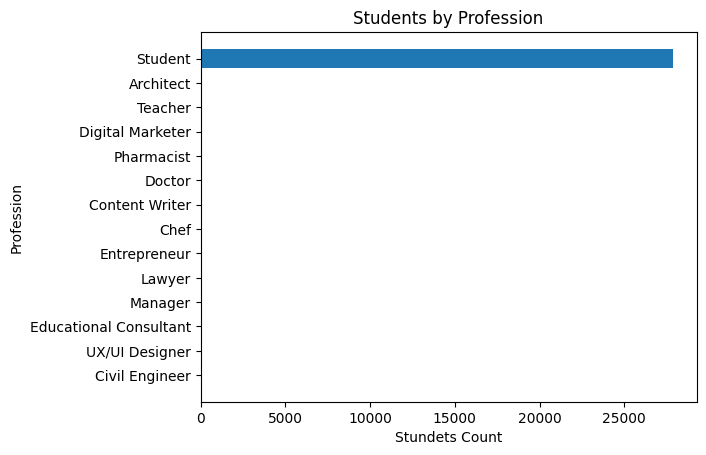

In [35]:
profession_stats = student_depression_data['profession'].value_counts(ascending=True)

professions = profession_stats.index
counts = profession_stats.values

# Horizontal bar chart so that profession names are fully visible
plt.barh(professions, counts)
plt.title("Students by Profession")
plt.xlabel("Stundets Count")
plt.ylabel("Profession")

plt.show()

As the name of the dataset suggests, it is about student. Data also shows it by having too little of the ramaining values. That is why I am going to assume that any other profession is not usable for any hypothesis and any row that is not a student will be considered to be an outlier and therefore be removed.

In [36]:
student_depression_data = student_depression_data[student_depression_data.profession == "Student"]

Let's not forget to rename the Work/Study Hours (that now is work_study_hours) since it would not make sense otherwise

In [37]:
student_depression_data = student_depression_data.rename(columns={"work_study_hours": "study_hours"})

We can also see that there are very few students that have a value for the column Job Satisfaction. However, the profession is Student. These students could either be studying and working or only studying but since the value in the previously named column Work/Job Hours was in one place, I will assume that this data is redundant and could be deleted.

In [38]:
student_depression_data.job_satisfaction.value_counts()

job_satisfaction
0.0    27862
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [39]:
student_depression_data = student_depression_data[student_depression_data.job_satisfaction == 0]
student_depression_data = student_depression_data.drop(columns=["job_satisfaction"])

Here we can see that there are diferent values for Work Pressure and since we already decided to test only for students that are not employed, I am going to drop those that are equal to 0

In [40]:
student_depression_data.work_pressure.value_counts()

work_pressure
0.0    27862
Name: count, dtype: int64

In [41]:
student_depression_data = student_depression_data.drop(columns=["work_pressure"])

Since we removed all records where the Profession column has a value diferrent than Student we can remove the whole column since it does not bring any new knowledge

In [42]:
student_depression_data = student_depression_data.drop(columns=["profession"])

Now in order to be more consistent I will translate the values of the folowing columns to 0 and 1 instead of Yes or No:

Have you ever had suicidal thoughts ?
Family History of Mental Illness

And the gender column to:

Male = 0 and Female = 1

But let's first see if there are values that are not Yes or No and Male or Female.

I encode male and female as 0 and 1 because there aren't other values and I assume such won't be added

In [43]:
binary_encode(student_depression_data, "have_you_ever_had_suicidal_thoughts")
binary_encode(student_depression_data, "family_history_of_mental_illness")
binary_encode(student_depression_data, "gender", "Male", "Female")

We have some ordinary categorical values that must be converted to numerical

I've picked *sleep_duration* and *dietary_habits* because both can be ordered incrementally.

Let's begin with *dietary_habits*.

First we need to see all possible values and order them incrementally.

In [44]:
student_depression_data.dietary_habits.unique()

array(['Healthy', 'Moderate', 'Unhealthy', 'Others'], dtype=object)

As we can see, we have four unique values. It is easy to order them like this: [Healthy, Moderate, Unhealthy] in somewhat of a descending order. I choose this order because of the semantics of the dataset. Because the dataset is about depression, it is logical *Healhy* to be the lowest.

However, there is a slight problem. There is also a *Others* value. What should we do with it?

In [45]:
student_depression_data.dietary_habits.value_counts()

dietary_habits
Unhealthy    10307
Moderate      9905
Healthy       7638
Others          12
Name: count, dtype: int64

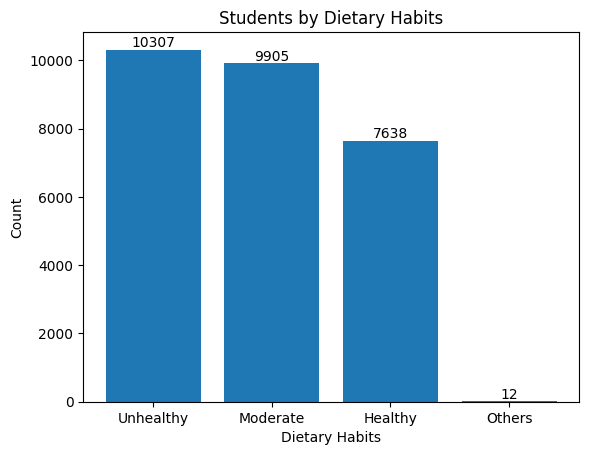

In [46]:
plot_category_counts(student_depression_data, "dietary_habits", title="Students by Dietary Habits", xlabel="Dietary Habits")

As we can see the case with the value *Others* is similar to the *profession* column we removed. It brings little to no entropy and we can just remove those values.

In [47]:
student_depression_data = student_depression_data[student_depression_data.dietary_habits != "Others"]

And we can finally convert the ordinal values to numerical using the *ordinal_encode* function.

???sleep_duration???

In [48]:
student_depression_data.sleep_duration.unique()

array(['5-6 hours', 'Less than 5 hours', '7-8 hours', 'More than 8 hours',
       'Others'], dtype=object)

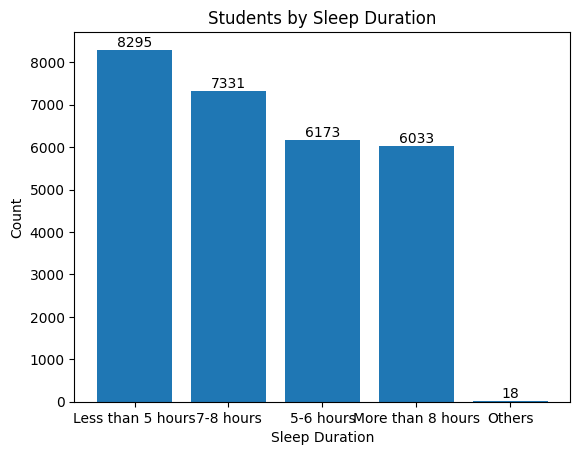

In [49]:
plot_category_counts(student_depression_data, "sleep_duration", title="Students by Sleep Duration", xlabel="Sleep Duration")

As we can see the situation of *sleep_duration* is similar to that of *dietary_habits* so we can again delete rows where the value is *Others*

In [50]:
student_depression_data = student_depression_data[student_depression_data.sleep_duration != "Others"]

In [51]:
ordinal_encode(student_depression_data, "dietary_habits", ["Healthy", "Moderate", "Unhealthy"])
ordinal_encode(student_depression_data, "sleep_duration", ["More than 8 hours", "7-8 hours", "5-6 hours", "Less than 5 hours"])

Finally, let's check if there are other than 1 and 0 in the depression column

In [52]:
student_depression_data.depression.value_counts()

depression
1    16287
0    11545
Name: count, dtype: int64

This is what the dataset looks after the cleanup

In [53]:
student_depression_data

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,study_hours,financial_stress,family_history_of_mental_illness,depression
0,1,33.0,Visakhapatnam,5.0,8.97,2.0,2.0,0.0,B.Pharm,1,3.0,1.0,0,1
1,0,24.0,Bangalore,2.0,5.90,5.0,2.0,1.0,BSc,0,3.0,2.0,1,0
2,1,31.0,Srinagar,3.0,7.03,5.0,3.0,0.0,BA,0,9.0,1.0,1,0
3,0,28.0,Varanasi,3.0,5.59,2.0,1.0,1.0,BCA,1,4.0,5.0,1,1
4,0,25.0,Jaipur,4.0,8.13,3.0,2.0,1.0,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27.0,Surat,5.0,5.75,5.0,2.0,2.0,Class 12,1,7.0,1.0,1,0
27897,1,27.0,Ludhiana,2.0,9.40,3.0,3.0,0.0,MSc,0,0.0,3.0,1,0
27898,1,31.0,Faridabad,3.0,6.61,4.0,2.0,2.0,MD,0,12.0,2.0,0,0
27899,0,18.0,Ludhiana,5.0,6.88,2.0,3.0,0.0,Class 12,1,10.0,5.0,0,1


The dataset looks good. Let's now proceed with the second dataset about depression.

### Depression

In [9]:
extract_zip("data/depression_data.csv.zip", "data")
depression_data = pd.read_csv('data/depression_data.csv')

In [10]:
depression_data

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No


In [11]:
depression_data.columns = [to_snake_case(c) for c in depression_data.columns]

To begin the cleanup of the dataset, we will get rid of the *name* column because we won't need it in any way.

In [12]:
depression_data = depression_data.drop(columns=["name"])

We can notice there are bunch of categorical values. Let's explore and convert them if needed

In [13]:
print("Nominal")
print(f"\tmarital_status => {depression_data.marital_status.unique()}")
print(f"\tsmoking_status => {depression_data.smoking_status.unique()}")
print(f"\temployment_status => {depression_data.employment_status.unique()}")
print("Binary")
print(f"\thistory_of_mental_illness => {depression_data.history_of_mental_illness.unique()}")
print(f"\thistory_of_substance_abuse => {depression_data.history_of_substance_abuse.unique()}")
print(f"\tfamily_history_of_depression => {depression_data.family_history_of_depression.unique()}")
print(f"\tchronic_medical_conditions => {depression_data.chronic_medical_conditions.unique()}")

Nominal
	marital_status => ['Married' 'Widowed' 'Divorced' 'Single']
	smoking_status => ['Non-smoker' 'Former' 'Current']
	employment_status => ['Unemployed' 'Employed']
Binary
	history_of_mental_illness => ['Yes' 'No']
	history_of_substance_abuse => ['No' 'Yes']
	family_history_of_depression => ['Yes' 'No']
	chronic_medical_conditions => ['Yes' 'No']


Let's now check Yes or No columns and convert them to 1 and 0

In [14]:
print(f"history_of_mental_illness => {depression_data.history_of_mental_illness.unique()}")
print(f"history_of_substance_abuse => {depression_data.history_of_substance_abuse.unique()}")
print(f"family_history_of_depression => {depression_data.family_history_of_depression.unique()}")
print(f"chronic_medical_conditions => {depression_data.chronic_medical_conditions.unique()}")

history_of_mental_illness => ['Yes' 'No']
history_of_substance_abuse => ['No' 'Yes']
family_history_of_depression => ['Yes' 'No']
chronic_medical_conditions => ['Yes' 'No']


As we can see, *history_of_mental_illness*, *history_of_substance_abuse*, *family_history_of_depression* and *chronic_medical_conditions* contain Yes or No values which means we can convert them to 1 or 0

In [52]:
binary_encode(depression_data, "history_of_mental_illness")
binary_encode(depression_data, "history_of_substance_abuse")
binary_encode(depression_data, "family_history_of_depression")
binary_encode(depression_data, "chronic_medical_conditions")

In [ ]:
# todo: convert ordinal

Ordinal variables are: *education_level*, *physical_activity_level*, *alcohol_consumption*, *dietary_habits* and *sleep_patterns* and as we've discussed earlier, less positive values will be ordered higher.

Let's see all values in those columns

In [53]:
print(f"education_level => {depression_data.education_level.unique()}")
print(f"physical_activity_level => {depression_data.physical_activity_level.unique()}")
print(f"alcohol_consumption => {depression_data.alcohol_consumption.unique()}")
print(f"dietary_habits => {depression_data.dietary_habits.unique()}")
print(f"sleep_patterns => {depression_data.sleep_patterns.unique()}")

education_level => ["Bachelor's Degree" 'High School' "Master's Degree" 'Associate Degree'
 'PhD']
physical_activity_level => ['Active' 'Sedentary' 'Moderate']
alcohol_consumption => ['Moderate' 'High' 'Low']
dietary_habits => ['Moderate' 'Unhealthy' 'Healthy']
sleep_patterns => ['Fair' 'Good' 'Poor']


All values are valid for convertion so we can order them, again from most postive to most negative

In [54]:
ordinal_encode(
    depression_data,
    "education_level",
    ["PhD", "Master's Degree", "Bachelor's Degree", "Associate Degree", "High School"]
)

ordinal_encode(
    depression_data,
    "physical_activity_level",
    ["Active", "Moderate", "Sedentary"]
)

ordinal_encode(
    depression_data,
    "alcohol_consumption",
    ["High", "Moderate", "Low"]
)

ordinal_encode(
    depression_data,
    "dietary_habits",
    ["Healthy", "Moderate", "Unhealthy"]
)

ordinal_encode(
    depression_data,
    "sleep_patterns",
    ["Good", "Fair", "Poor"]
)

In [ ]:
# todo: convert nominal

Something about salary, age number_of_children, income

In [55]:
depression_data

,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,31,Married,2.0,2,Non-smoker,0.0,Unemployed,26265.67,1.0,1.0,1.0,1,0,1,1
1,55,Married,4.0,1,Non-smoker,2.0,Employed,42710.36,0.0,2.0,1.0,1,0,0,1
2,78,Widowed,1.0,1,Non-smoker,2.0,Employed,125332.79,2.0,2.0,0.0,0,0,1,0
3,58,Divorced,1.0,3,Non-smoker,1.0,Unemployed,9992.78,1.0,1.0,2.0,0,0,0,0
4,18,Single,4.0,0,Non-smoker,2.0,Unemployed,8595.08,2.0,1.0,1.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,68,Married,1.0,0,Former,1.0,Employed,109233.43,2.0,0.0,0.0,0,0,0,0
413764,26,Single,2.0,0,Current,0.0,Employed,96760.97,2.0,0.0,2.0,1,1,0,1
413765,57,Married,2.0,0,Non-smoker,2.0,Employed,77353.26,1.0,1.0,1.0,0,0,1,1
413766,71,Married,3.0,2,Non-smoker,2.0,Unemployed,24557.08,1.0,1.0,2.0,0,1,0,0


### Enhanced Anxiety

In [35]:
enhanced_anxiety_data = pd.read_csv('data/enhanced_anxiety_dataset.csv')

In [36]:
enhanced_anxiety_data

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,91,28,1,Yes,Yes,1,No,3,6.0
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,95,17,3,No,No,2,No,7,3.0
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,72,16,1,Yes,Yes,2,Yes,7,4.0
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,112,28,3,Yes,Yes,1,Yes,2,4.0


In [37]:
enhanced_anxiety_data.columns = [to_snake_case(c) for c in enhanced_anxiety_data.columns]

In [39]:
print(f"smoking => {enhanced_anxiety_data.smoking.unique()}")
print(f"family_history_of_anxiety => {enhanced_anxiety_data.family_history_of_anxiety.unique()}")
print(f"dizziness => {enhanced_anxiety_data.dizziness.unique()}")
print(f"medication => {enhanced_anxiety_data.medication.unique()}")
print(f"recent_major_life_event => {enhanced_anxiety_data.recent_major_life_event.unique()}")

smoking => ['Yes' 'No']
family_history_of_anxiety => ['No' 'Yes']
dizziness => ['No' 'Yes']
medication => ['Yes' 'No']
recent_major_life_event => ['Yes' 'No']


In [40]:
binary_encode(enhanced_anxiety_data, "smoking")
binary_encode(enhanced_anxiety_data, "family_history_of_anxiety")
binary_encode(enhanced_anxiety_data, "dizziness")
binary_encode(enhanced_anxiety_data, "medication")
binary_encode(enhanced_anxiety_data, "recent_major_life_event")

In [41]:
print(f"gender => {enhanced_anxiety_data.gender.unique()}")

gender => ['Female' 'Other' 'Male']


We can notice that in this dataset exist records whose gender is *other*.

Let's check the distribution of the column so we know what to do with those rows.

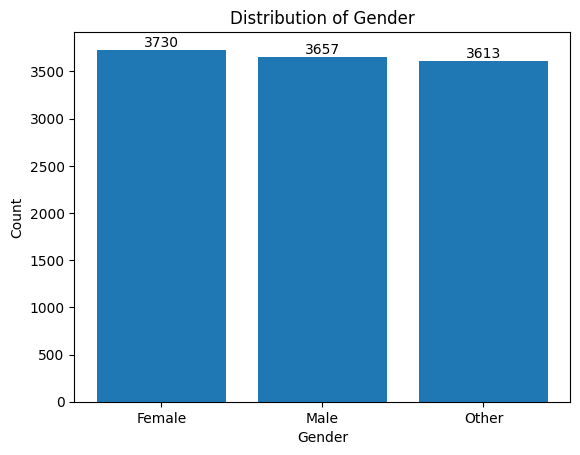

In [43]:
plot_category_counts(enhanced_anxiety_data, "gender", title="Distribution of Gender", xlabel="Gender")

As we can see we have roughly an uniform distribution of the gender columns and having it removed will make a great bias.

Having said that, the *gender* column's type is no longer binary but nominal.

Therefore, *one-hot-encoding* is the appropriate method to represent it as numbers without creating artificial order.

In [ ]:
# one-hot encode gender

### Ocd Patient Dataset

In [63]:
ocd_patient_data = pd.read_csv('data/ocd_patient_dataset.csv')

In [117]:
ocd_patient_data

,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,duration_of_symptoms_months,previous_diagnoses,family_history_of_ocd,obsession_type,compulsion_type,y_bocs_score_obsessions,y_bocs_score_compulsions,depression_diagnosis,anxiety_diagnosis,medications
0,32,0,African,Single,2.0,2016-07-15,203,MDD,0,Harm-related,Checking,17,10,1,1,SNRI
1,69,1,African,Divorced,2.0,2017-04-28,180,NaN,1,Harm-related,Washing,21,25,1,1,SSRI
2,57,1,Hispanic,Divorced,1.0,2018-02-02,173,MDD,0,Contamination,Checking,3,4,0,0,Benzodiazepine
3,27,0,Hispanic,Married,1.0,2014-08-25,126,PTSD,1,Symmetry,Washing,14,28,1,1,SSRI
4,56,0,Hispanic,Married,3.0,2022-02-20,168,PTSD,1,Hoarding,Ordering,39,18,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,38,1,Hispanic,Divorced,1.0,2019-01-10,53,MDD,0,Contamination,Washing,21,33,1,1,SSRI
1496,19,0,Hispanic,Divorced,0.0,2022-09-14,160,GAD,1,Hoarding,Praying,25,16,1,1,SSRI
1497,40,1,Asian,Married,2.0,2018-03-13,100,NaN,1,Contamination,Counting,2,15,1,1,Benzodiazepine
1498,37,0,Caucasian,Married,2.0,2018-04-14,210,GAD,1,Contamination,Washing,16,7,1,0,Benzodiazepine


In [65]:
ocd_patient_data.columns = [to_snake_case(c) for c in ocd_patient_data.columns]

Again, we don't need the *patient_id* column so we'll be removing it.

In [66]:
ocd_patient_data = ocd_patient_data.drop(columns=["patient_id"])

In [67]:
print(f"family_history_of_ocd => {ocd_patient_data.family_history_of_ocd.unique()}")
print(f"depression_diagnosis => {ocd_patient_data.depression_diagnosis.unique()}")
print(f"anxiety_diagnosis => {ocd_patient_data.anxiety_diagnosis.unique()}")

family_history_of_ocd => ['No' 'Yes']
depression_diagnosis => ['Yes' 'No']
anxiety_diagnosis => ['Yes' 'No']


In [68]:
binary_encode(ocd_patient_data, "family_history_of_ocd")
binary_encode(ocd_patient_data, "depression_diagnosis")
binary_encode(ocd_patient_data, "anxiety_diagnosis")

As we've seen in the previos dataset, the gender column could consist of more than one value. Let's check.

In [69]:
ocd_patient_data.gender.unique()

array(['Female', 'Male'], dtype=object)

We can safely convert to 1 and 0

In [70]:
binary_encode(ocd_patient_data, "gender", val1="Male", val2="Female")

Education Level

In [71]:
ocd_patient_data.education_level.unique()

array(['Some College', 'College Degree', 'High School', 'Graduate Degree'],
      dtype=object)

In [72]:
ordinal_encode(
    ocd_patient_data,
    "education_level",
    ["Graduate Degree", "College Degree", "Some College", "High School"]
)

Check if depression or anxiety are diferent than Yes or No

In [ ]:
print(ocd_patient_data.depression_diagnosis.unique())
print(ocd_patient_data.anxiety_diagnosis.unique())

[1 0]
[1 0]


Check obsessions and compulsions

In [119]:
print(ocd_patient_data.y_bocs_score_obsessions.unique())
print(ocd_patient_data.y_bocs_score_compulsions.unique())
print(ocd_patient_data.obsession_type.unique())
print(ocd_patient_data.compulsion_type.unique())

[17 21  3 14 39 26 12 31 37 28 40  4 10 23  7 38 22  0 30  1 32 29 19  9
 18 20 27 34  8 36 16 13 11 35  2 15 33 25  6  5 24]
[10 25  4 28 18 11 16 24 36 26 27 39 21 20 22 12 40  5  8  0 13 38 31 34
 37 15  1 32  3  9 33  6 19  7 30 14  2 23 35 29 17]
['Harm-related' 'Contamination' 'Symmetry' 'Hoarding' 'Religious']
['Checking' 'Washing' 'Ordering' 'Praying' 'Counting']


### Mental Disorder Symptoms

In [45]:
xlsx_to_csv("data/Mental disorder symptoms.xlsx", "data/Mental disorder symptoms.csv")
mental_disorder_data = pd.read_csv('data/Mental disorder symptoms.csv')

In [46]:
mental_disorder_data

,ag+1:629e,feeling.nervous,panic,breathing.rapidly,sweating,trouble.in.concentration,having.trouble.in.sleeping,having.trouble.with.work,hopelessness,anger,...,having.nightmares,avoids.people.or.activities,feeling.negative,trouble.concentrating,blamming.yourself,hallucinations,repetitive.behaviour,seasonally,increased.energy,Disorder
0,23,1,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,MDD
1,14,1,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,ASD
2,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Loneliness
3,29,1,0,0,0,1,1,0,0,0,...,0,0,0,1,1,0,0,0,1,bipolar
4,32,1,1,1,1,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,anexiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,23,1,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,eating disorder
633,27,1,0,1,0,0,0,0,1,1,...,1,0,1,1,1,0,0,0,0,PDD
634,19,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,1,ASD
635,16,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Loneliness


In [47]:
mental_disorder_data.columns = [to_snake_case(c) for c in mental_disorder_data.columns]

The column *ag_1_629e* seems to have an uncommon name. There is no explanaition in the source. However, we can make some assumtions about it.

First of all, let's see what data is there, its distribution and max, min, average, mean and quarteds values

In [48]:
mental_disorder_data.ag_1_629e.describe()

count    637.000000
mean      22.189953
std        8.395680
min        4.000000
25%       16.000000
50%       21.000000
75%       28.000000
max       46.000000
Name: ag_1_629e, dtype: float64

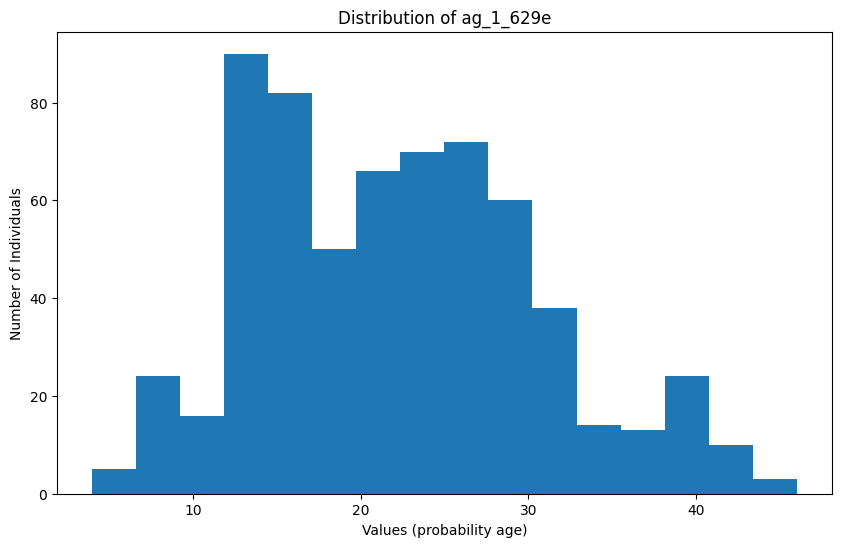

In [49]:
plt.figure(figsize=(10,6))
plt.hist(mental_disorder_data.ag_1_629e, bins="auto")

plt.title("Distribution of ag_1_629e")
plt.xlabel("Values (probability age)")
plt.ylabel("Number of Individuals")

plt.show()

The distribution is multimodal, with three distinct peaks around 12, 27, and 42, indicating separate clusters within the data.

The column name starts with 'ag', the values are within a plausible human age range, and the peaks align with typical age groups, suggesting it likely represents Age.

In [50]:
mental_disorder_data = mental_disorder_data.rename(columns={"ag_1_629e": "age"})

Let's now check for binary data and since we have a lot of columns we could automate it.

In [51]:
mental_disorder_data.dtypes

age                             int64
feeling_nervous                 int64
panic                           int64
breathing_rapidly               int64
sweating                        int64
trouble_in_concentration        int64
having_trouble_in_sleeping      int64
having_trouble_with_work        int64
hopelessness                    int64
anger                           int64
over_react                      int64
change_in_eating                int64
suicidal_thought                int64
feeling_tired                   int64
close_friend                    int64
social_media_addiction          int64
weight_gain                     int64
introvert                       int64
popping_up_stressful_memory     int64
having_nightmares               int64
avoids_people_or_activities     int64
feeling_negative                int64
trouble_concentrating           int64
blamming_yourself               int64
hallucinations                  int64
repetitive_behaviour            int64
seasonally  

In [52]:
binary_cols = [
    col for col in mental_disorder_data.columns 
]

binary_df = pd.DataFrame({
    "Column": binary_cols,
    "Type": [mental_disorder_data[col].dtype for col in binary_cols],
    "Values": [mental_disorder_data[col].dropna().unique().tolist() for col in binary_cols]
})

binary_df

,Column,Type,Values
0,age,int64,"[23, 14, 25, 29, 32, 40, 18, 24, 37, 4, 27, 15..."
1,feeling_nervous,int64,"[1, 0]"
2,panic,int64,"[0, 1]"
3,breathing_rapidly,int64,"[1, 0]"
4,sweating,int64,"[0, 1]"
5,trouble_in_concentration,int64,"[0, 1]"
6,having_trouble_in_sleeping,int64,"[1, 0]"
7,having_trouble_with_work,int64,"[0, 1]"
8,hopelessness,int64,"[1, 0]"
9,anger,int64,"[0, 1]"


We can see that only the *age*, *seasonally*, and *disorder* columns are not binary, and all binary columns are already converted to 1 and 0. Therefore, we won't need to convert anything.

Solely, the *seasonally* column has only one value (0), which means it brings zero entropy and, therefore, could be removed.

In [53]:
mental_disorder_data = mental_disorder_data.drop(columns=["seasonally"])

## Some hypothesis

We are done cleaning the data and for our hypothesis we'll need some functions

Before writing the tests functions, we need functions to determine the distributions types

First function is the *Shapiro test*. We will need it to check if data has normal distribution

In [83]:
def shapiro_test(data, column, alpha = 0.05):
    """
    Performs Shapiro-Wilk test for normality on a specified column.

    Parameters:
    - data: pd.DataFrame containing the data
    - column: str, name of the column to test
    - alpha: significance level (default = 0.05)

    Prints the test statistic, p-value, and interpretation.
    """
    if column not in data.columns:
        print(f"Column '{column}' not found in DataFrame.")
        return

    # Drop missing values
    values = data[column].dropna()

    # Perform Shapiro-Wilk test
    stat, p_value = st.shapiro(values)

    print(f"Shapiro-Wilk Test for '{column}':")
    print(f"Test Statistic = {stat:.4f}")
    print(f"p-value = {p_value:.4f}")

    if p_value < alpha:
        print("Result: Data is NOT normally distributed (reject H₀)")
    else:
        print("Result: Data appears to be normally distributed (fail to reject H₀)")

However, if you run the function on a larger dataset, you will notice that there is a warning that says that the shapiro method may return not so accurate p-value when it is given more than ~5000 elements.

For this reason we are going to implement a very similar function that instead uses the *Kolmogorov-Smirnov* test.

In [84]:
def kolmogorov_smirnov_test(data, column, alpha):
    """
    Performs Kolmogorov-Smirnov test for normality on a specified column.

    Parameters:
    - data: pd.DataFrame containing the data
    - column: str, name of the column to test
    - alpha: significance level (default = 0.05)

    Prints the test statistic, p-value, and interpretation.
    """
    if column not in data.columns:
        print(f"Column '{column}' not found in DataFrame.")
        return

    values = data[column].dropna()

    # Normalize the data (standardize to mean=0, std=1)
    standardized = (values - values.mean()) / values.std()

    # Perform Kolmogorov-Smirnov test against normal distribution
    stat, p_value = st.kstest(standardized, "norm")

    print(f"Kolmogorov-Smirnov Test for '{column}':")
    print(f"Test Statistic = {stat:.4f}")
    print(f"p-value = {p_value:.4f}")

    if p_value < alpha:
        print("Result: Data is NOT normally distributed (reject H₀)")
    else:
        print("Result: Data appears to be normally distributed (fail to reject H₀)")

And now that we have them, we can start implementing the test functions

The first of them will compare categories. We will be using the Chi-Squared test

In [55]:
def chi_square(df, col, depression_col="depression"):
    # Create contingency table
    table = pd.crosstab(df[col], df[depression_col])
    print("Observed values:")
    display(table)

    # Chi-square test
    chi2, p, dof, expected = st.chi2_contingency(table)
    print(f"Chi2: {chi2:.4f}")
    print(f"p-value: {p:.4e}")
    print(f"Degrees of freedom: {dof}")
    print("Expected values:")
    display(pd.DataFrame(expected, index=table.index, columns=table.columns))

    # Conclusion
    if p < 0.05:
        print(f"Conclusion: There is a statistically significant relationship between '{col}' and '{depression_col}' (p < 0.05).")
    else:
        print(f"Conclusion: There is no statistically significant relationship between '{col}' and '{depression_col}' (p ≥ 0.05).")

    # Visualization
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x=col, hue=depression_col, palette="Set2")

    # Title with p-value
    plt.title(f"Distribution of '{depression_col}' by '{col}' (p = {p:.4e})", fontsize=14)

    # Labels
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Number of participants", fontsize=12)

    # Legend with actual category names
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title=depression_col)

    # Add counts on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()

Second function will be used to compare the mean of three or more groups. Maybe coming as a surprise, we are not going to implement ANOVA. The function will be the *Kruskal-Wallis test*. The reason why will be explained later in the document.

In [1]:
# Kruskal-Wallis test

The third function is going to compare the median of two categories or one category's median to a number. Again, possiply as a surprise, the function we'll be implementing will not be the *t-test*, but *Mann-Whitney U*. Again the reason will be explained later in the document.

In [2]:
# Mann-Whitney U

Of course, we will need a function to find correlation between data. For this goal we will be using the *Pearson* and the *Spearmanr* functions

In [9]:
# Pearson

And if the data is not normally distributed

In [10]:
# Spearman

The hypothesises I've planned to prove or reject are all related to the three mental disorders from the five datasets we've spent so much time on cleaning and preparing.

1 Determine if the Academic pressure or the financial stress of a have something to do with the causation of depression. Also check if family history of any mental illness.

2

3

4

5

### What may affect probability of depression

For this section, we have three tests and therefore three Null hypothesis.

$ H_0 $ Students that have high academic pressure aren't more likely to have depression.

$ H_A $ Students that have high academic pressure are more likely to have depression.

Observed values:


depression,0,1
academic_pressure,,
0.0,2,1
1.0,3866,931
2.0,2608,1561
3.0,2966,4474
4.0,1227,3915
5.0,876,5405


Chi2: 6413.7891
p-value: 0.0000e+00
Degrees of freedom: 5
Expected values:


depression,0,1
academic_pressure,,
0.0,1.244431,1.755569
1.0,1989.844963,2807.155037
2.0,1729.344100,2439.655900
3.0,3086.188560,4353.811440
4.0,2132.954513,3009.045487
5.0,2605.423433,3675.576567


Conclusion: There is a statistically significant relationship between 'academic_pressure' and 'depression' (p < 0.05).


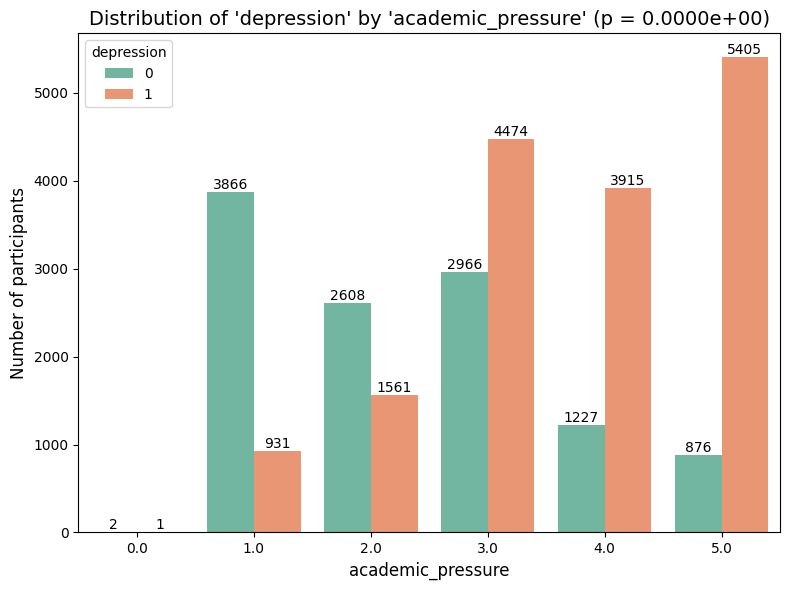

In [56]:
chi_square(student_depression_data, col="academic_pressure")

As we can see, the p-value is 0.0000e+00 which is significantly less than 0.05 and the expected values are very diferent than the observed. Therefore we can safely conclude that the $ H_0 $ can be rejected and the academic pressure actually affects students depression.

Let's now make two more tests

$ H_0 $ Students that have high financial stress aren't more likely to have depression.

$ H_A $ Students that have high financial stress are more likely to have depression.

Observed values:


depression,0,1
family_history_of_mental_illness,,
0,6321,8038
1,5224,8249


Chi2: 78.6290
p-value: 7.4942e-19
Degrees of freedom: 1
Expected values:


depression,0,1
family_history_of_mental_illness,,
0,5956.260959,8402.739041
1,5588.739041,7884.260959


Conclusion: There is a statistically significant relationship between 'family_history_of_mental_illness' and 'depression' (p < 0.05).


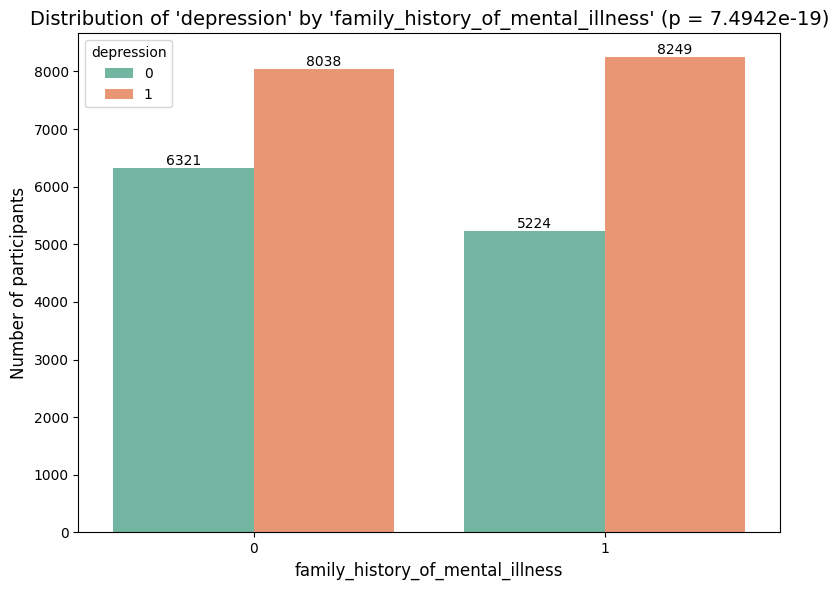

In [58]:
chi_square(student_depression_data, col="family_history_of_mental_illness")

Observed values:


depression,0,1
gender,,
0,5127,7199
1,6418,9088


Chi2: 0.1101
p-value: 7.4001e-01
Degrees of freedom: 1
Expected values:


depression,0,1
gender,,
0,5112.951638,7213.048362
1,6432.048362,9073.951638


Conclusion: There is no statistically significant relationship between 'gender' and 'depression' (p ≥ 0.05).


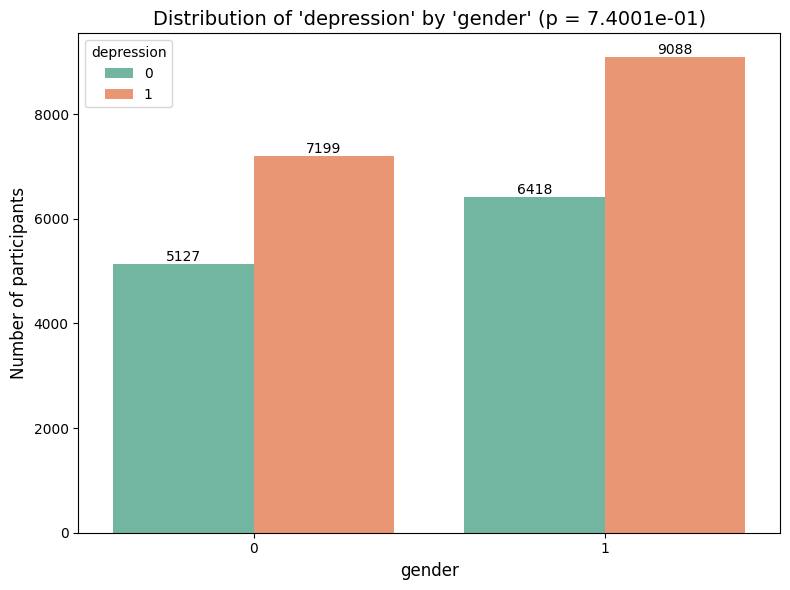

In [59]:
chi_square(student_depression_data, col="gender")

### Anxiety

### Obsessive Compulsive Disorder

The questions we are going to ask are the following

Do people that have only one - depression or anxiety have symptoms of OCD for longer or not?

Do people that have both depression and anxiety have symptoms of OCD for longer than those who have neither?

In [81]:
# 0 for not having the diagnosis and 1 for having it
def filter_by_conditions(df, depression = 0, anxiety = 0):
    return df[
        (df.depression_diagnosis == depression) &
        (df.anxiety_diagnosis == anxiety)
    ]

In [82]:
ocd_depression = filter_by_conditions(ocd_patient_data, depression = 1)
ocd_anxiety = filter_by_conditions(ocd_patient_data, anxiety = 1)
ocd_both = filter_by_conditions(ocd_patient_data, depression = 1, anxiety = 1)
ocd_neither = filter_by_conditions(ocd_patient_data)

Let's put them in collection

In [ ]:
groups = [ocd_depression, ocd_anxiety, ocd_both, ocd_neither]

,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,duration_of_symptoms_months,previous_diagnoses,family_history_of_ocd,obsession_type,compulsion_type,y_bocs_score_obsessions,y_bocs_score_compulsions,depression_diagnosis,anxiety_diagnosis,medications
2,57,1,Hispanic,Divorced,1.0,2018-02-02,173,MDD,0,Contamination,Checking,3,4,0,0,Benzodiazepine
4,56,0,Hispanic,Married,3.0,2022-02-20,168,PTSD,1,Hoarding,Ordering,39,18,0,0,NaN
14,48,0,Caucasian,Divorced,3.0,2020-08-24,141,MDD,1,Harm-related,Washing,23,39,0,0,SNRI
18,50,0,African,Single,2.0,2017-11-04,62,NaN,1,Hoarding,Washing,22,22,0,0,NaN
22,28,1,Caucasian,Single,1.0,2016-08-23,208,PTSD,0,Contamination,Checking,32,16,0,0,SNRI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,75,0,Caucasian,Married,2.0,2022-02-25,173,NaN,0,Contamination,Ordering,36,10,0,0,SSRI
1482,19,0,Asian,Single,2.0,2014-03-05,171,PTSD,1,Symmetry,Counting,6,7,0,0,SNRI
1483,23,0,Asian,Divorced,2.0,2017-05-07,78,PTSD,0,Symmetry,Counting,18,3,0,0,SNRI
1488,25,0,Caucasian,Single,2.0,2022-09-30,53,Panic Disorder,1,Contamination,Checking,34,18,0,0,Benzodiazepine


Now before proceeding to testing the means, we need to check the distributions for normality

In [101]:
[len(group) for group in groups]

[400, 379, 372, 349]

Since the size of the sets are small we can use the *Shapiro test*

In [ ]:
[shapiro_test(group, "duration_of_symptoms_months") for group in groups]

Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9662
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)
Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9421
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)
Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9415
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)
Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9651
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)


[None, None, None, None]

We see that the distributions of the data is not normal therefore neither *t-test* nor *ANOVA* can be used on them. This is why earlier we ceated the functions for *Mann-Whitney U* and *Kruskal-Wallis*

Let's begin by testing if patients with both deseases have something with patients that do not have.

In [104]:
# testing, showing and explaining results

Now let's make a more suffisticated test by comparing the four groups

In [105]:
# testing, showing and explaining results

Another interesting question is if the obsession or compulsion Y-BOCS Scores reflect on the obsession or compulsion type

To begin with, we'll again need to group the data

In [120]:
def extract_scores_by_group(df, group_col, score_col):
    return [
        group[score_col].dropna().values
        for _, group in df.groupby(group_col)
    ]

In [124]:
obsession_groups = extract_scores_by_group(
    df = ocd_patient_data,
    group_col = "obsession_type",
    score_col = "y_bocs_score_obsessions"
)

compulsions_groups = extract_scores_by_group(
    df = ocd_patient_data,
    group_col = "compulsion_type",
    score_col = "y_bocs_score_compulsions"
)

In [ ]:
def plot_violin_scores_by_group(df, group_col, score_col, title=None, figsize=(10, 6), palette="Set2"):
    plt.figure(figsize=figsize)

    sns.violinplot(
        data=df,
        x=group_col,
        y=score_col,
        hue=group_col,
        palette=palette,
        inner="box",
        cut=0,
        legend=False,
    )

    plt.xticks(rotation=45)
    plt.title(title or f"Violin Plot of {score_col} by {group_col}")
    plt.tight_layout()

    plt.show()

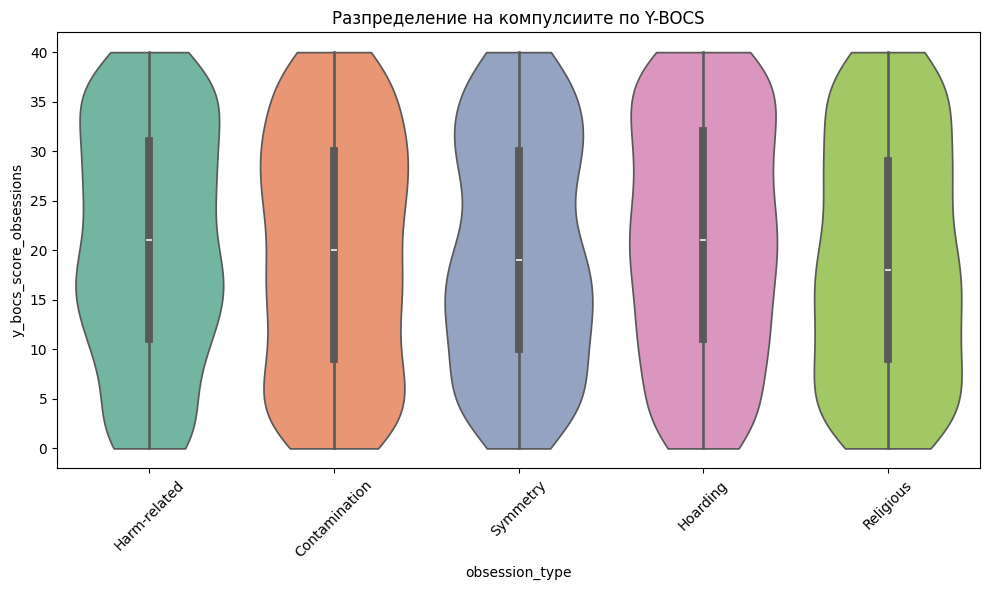

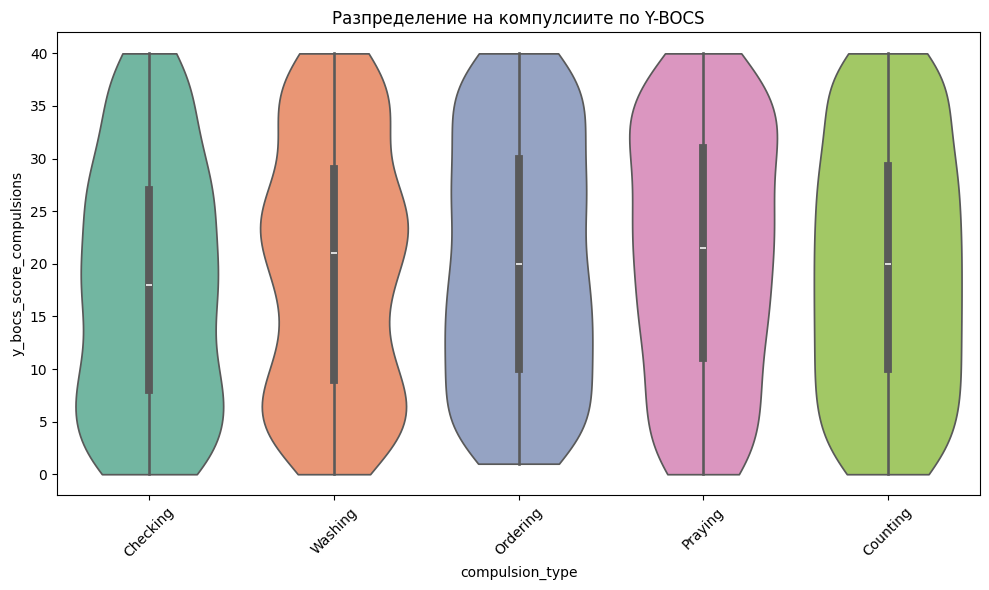

In [ ]:
plot_violin_scores_by_group(
    df=ocd_patient_data,
    group_col="obsession_type",
    score_col="y_bocs_score_obsessions",
    title="Разпределение на компулсиите по Y-BOCS"
)

plot_violin_scores_by_group(
    df=ocd_patient_data,
    group_col="compulsion_type",
    score_col="y_bocs_score_compulsions",
    title="Разпределение на компулсиите по Y-BOCS"
)

In [138]:
# Tests

## Some more serious data science (Regression maybe)

## Comparing behaviours in disorders

## Sources

[Student Depression Dataset.](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

[Depression Dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset)

[Social Anxiety Dataset](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data)

[Anxiety and Depression Mental Health Factors](https://www.kaggle.com/datasets/ak0212/anxiety-and-depression-mental-health-factors)

[OCD Patient Dataset: Demographics & Clinical Data](https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data)

[OCD_Social_Media_Dataset](https://www.kaggle.com/datasets/bhagvendersingh/ocd-social-media-dataset)

[Mental Disorders Dataset](https://www.kaggle.com/datasets/baselbakeer/mental-disorders-dataset/data)